# Deploy a Model on TrueFoundry

In this module we will deploy an already trained model on TrueFoundry


# 🛠 Setup

To follow along with the notebook, you will have to do the following:

- Install `truefoundry` and required ML Libraries
- Setup logging
- Select the Workspace in which you want to deploy your application.
- Install the required packages


In [ ]:
%pip install -U -q "truefoundry>=0.5.6,<0.6.0" "tensorflow==2.15.0" "matplotlib==3.8.2"

In [15]:
import logging

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(name)s] %(levelname)-8s %(message)s"
)

### Login into TrueFoundry

In order to login run the cell below. Host can be found from the TrueFoundry UI as shown below like https://app.truefoundry.com

![image.png](../common/images/host.png)

In [ ]:
!tfy login --host "<Host name of TrueFoundry UI. e.g. https://company.truefoundry.cloud>"

### Create a ML Repo

We will be using the ML Repo to store the model artifacts and results of our model training. You can create an ML Repo using the following the docs at: https://docs.truefoundry.com/docs/key-concepts#creating-an-ml-repo

### Select the `Workspace` in which you want to deploy your application.

Once you run the cell below you will get a prompt to enter your workspace. Follow the docs to

a. Create a Workspace: https://docs.truefoundry.com/docs/key-concepts#creating-a-workspace  
b. Grant Editor access to ML Repo we created above: https://docs.truefoundry.com/docs/key-concepts#grant-access-of-ml-repo-to-workspace  


Or, just get the workspace FQN for existing workspace with access: https://docs.truefoundry.com/docs/key-concepts#getting-workspace-fqn


Once done, you should have a workspace FQN that you can paste in the next cell when prompted

In [16]:
import click

In [ ]:
WORKSPACE_FQN = click.prompt(
    "Enter the Workspace FQN",
    type=str,
)
print(f"\nWorkspace FQN set to {WORKSPACE_FQN!r}")

## Loading the model saved in TrueFoundry

Grab the model version FQN from the Job Run details Models Tab.

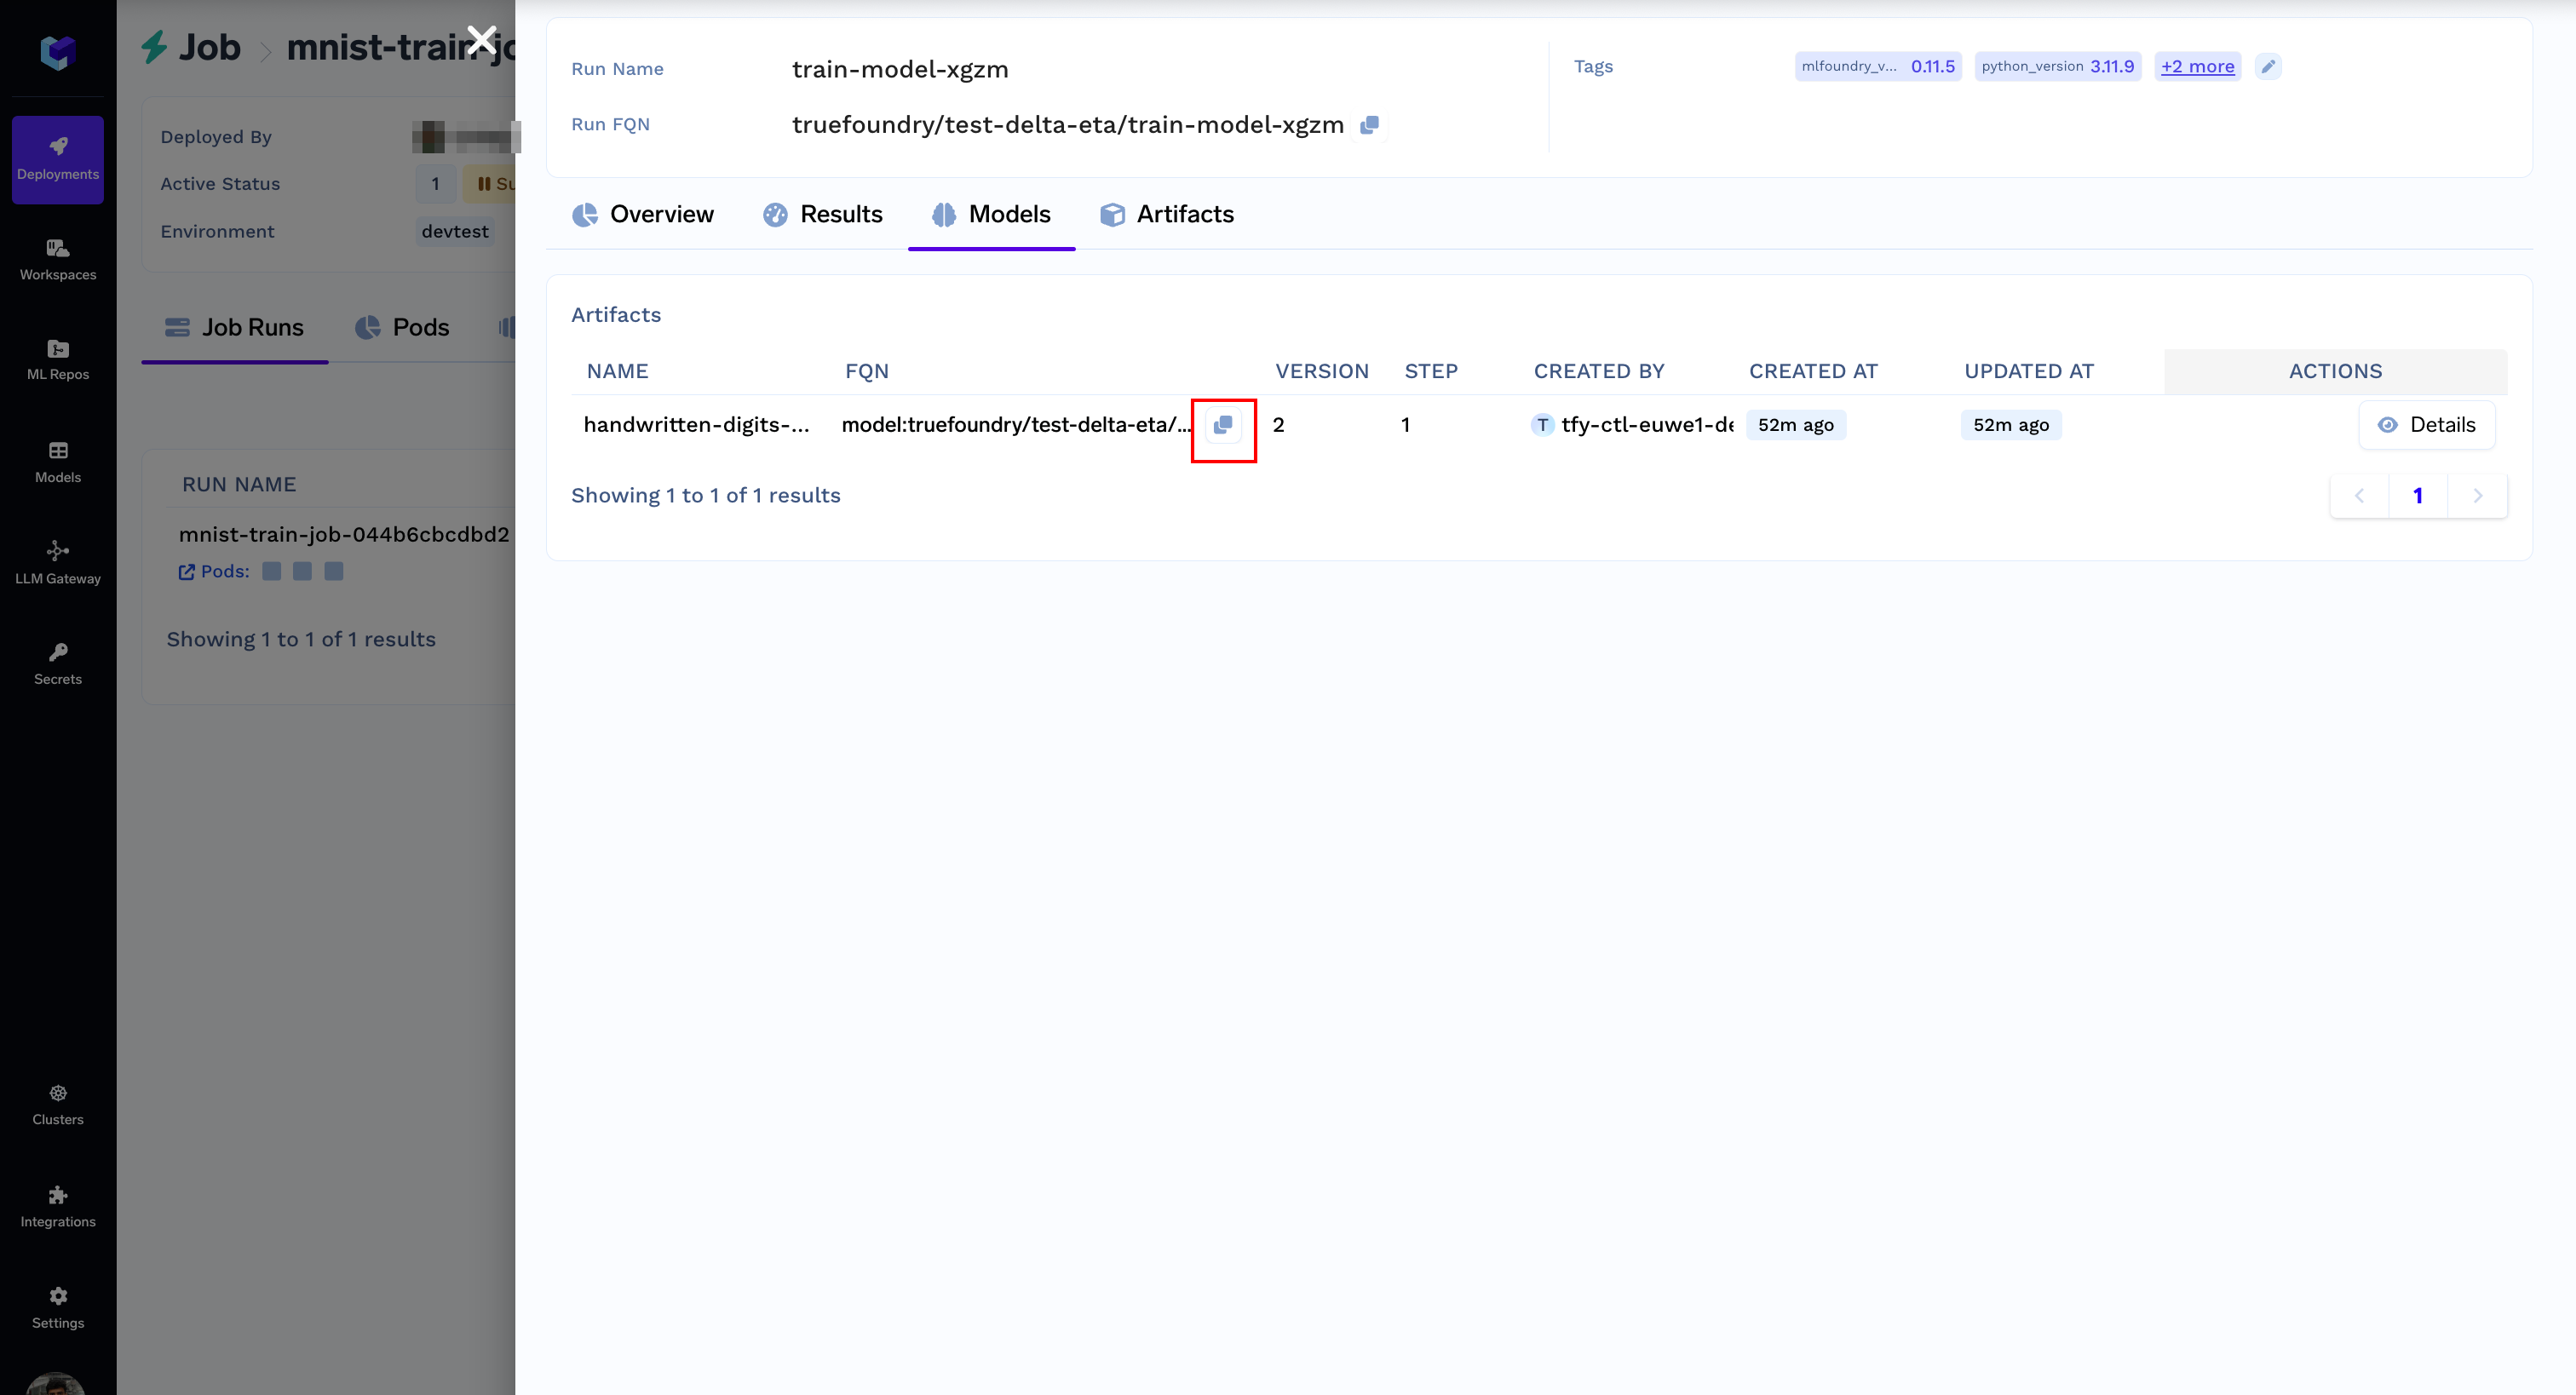

In [ ]:
MODEL_VERSION_FQN = click.prompt(
    "Enter the Model Version FQN (Can be found in run details of training job)",
    type=str,
)
print(f"\nModel Version FQN set to {MODEL_VERSION_FQN!r}")

In [ ]:
from truefoundry.ml import get_client
import os

client = get_client()
model_version = client.get_model_version_by_fqn(MODEL_VERSION_FQN)
os.makedirs("./model", exist_ok=True)
download_path = model_version.download("./model", overwrite=True)

model_file = os.path.join(download_path.model_dir, "mnist_model.h5")

In [ ]:
from deploy_model.predict import load_model, predict_fn

model = load_model(model_file)

## Try out a sample inference


In [ ]:
import tensorflow as tf

test_img = tf.keras.utils.load_img(
    "deploy_model/sample_images/3.jpg", target_size=(28, 28)
)
img_arr = tf.keras.preprocessing.image.img_to_array(test_img)

In [ ]:
test_img

In [ ]:
predict_fn(model, img_arr)

## Deploying the model


### Inference Scripts


In [1]:
!pygmentize deploy_model/predict.py

import numpy as np
import tensorflow as tf


def load_model(model_path: str) -> tf.keras.Model:
    # Load the trained model
    model = tf.keras.models.load_model(model_path)
    return model


def predict_fn(model, img_arr: np.ndarray) -> str:
    # Preprocess the image before passing it to the model
    img_arr = tf.expand_dims(img_arr, 0)
    img_arr = img_arr[:, :, :, 0]  # Keep only the first channel (grayscale)

    # Make predictions
    predictions = model.predict(img_arr)
    predicted_label = tf.argmax(predictions[0]).numpy()

    return str(predicted_label)


In [2]:
!pygmentize deploy_model/gradio_demo.py

import os

import gradio as gr
from predict import load_model, predict_fn

model_path = os.path.join(os.environ.get("MODEL_DOWNLOAD_PATH", "."), "mnist_model.h5")
model = load_model(model_path)


def get_inference(img_arr):
    return predict_fn(model, img_arr)


interface = gr.Interface(
    fn=get_inference,
    inputs="image",
    outputs="label",
    examples=[["sample_images/0.jpg"], ["sample_images/1.jpg"]],
)

interface.launch(
    server_name="0.0.0.0",
    server_port=8000,
    root_path=os.environ.get("TFY_SERVICE_ROOT_PATH"),
)


### Deploy on TrueFoundry as Service


In [3]:
!pygmentize deploy_model/deploy.py

import argparse
import logging

from truefoundry.deploy import (
    ArtifactsDownload,
    Build,
    LocalSource,
    Port,
    PythonBuild,
    Resources,
    Service,
    TruefoundryArtifactSource,
)

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(name)s] %(levelname)-8s %(message)s")


def str_or_none(value):
    return None if not value or value == "None" else value


parser = argparse.ArgumentParser()
parser.add_argument("--name", required=False, default="mnist-classifier", type=str, help="Name of the application.")
parser.add_argument(
    "--workspace_fqn",
    "--workspace-fqn",
    required=True,
    type=str,
    help="FQN of the workspace where application will be deployed",
)
parser.add_argument(
    "--host",
    required=True,
    type=str,
    help="Host where the application will be available for access. Ex:- my-app.my-org.com",
)
parser.add_argument(
    "--path",
    required=False,
    default=None,
    type=str_or_none,
    help="Path in addition t

We will need a endpoint to access the deployed service. This host should follow the base domain url configured in the cluster.

Please refer to following docs to get the base domain url to make your endpoint:

https://docs.truefoundry.com/docs/define-ports-and-domains#identifying-available-domains

In [ ]:
SERVICE_HOST = click.prompt(
    "Enter the host for the Service endpoint (e.g. my-service.org-domain.com OR org-domain.com)",
    type=str,
)
SERVICE_PATH = click.prompt(
    "Optionally, enter the path for Service endpoint (e.g. /my-service/). You can leave this blank if your domain supports subdomains: ",
    type=str,
    default=None,
)
SERVICE_PATH = f"/{SERVICE_PATH.strip('/')}/"

print(f"\nService Host set to {SERVICE_HOST!r}")
print(f"\nService Path set to {SERVICE_PATH!r}")

In [ ]:
!cd deploy_model/ && python deploy.py --workspace_fqn $WORKSPACE_FQN --model_version_fqn $MODEL_VERSION_FQN --host $SERVICE_HOST --path $SERVICE_PATH